# DIA - Label-Free

This tutorial demonstrates how to analyze label-free quantification data from data-independent acquisition (DIA) using the `msmu` package.

## Data Preparation

Original dataset is from [PXD012988](https://www.ebi.ac.uk/pride/archive/projects/PXD012988) (Uszkoreit _et al_., 2022) and search was performed with [`DIA-NN` v2.1.0](https://github.com/vdemichev/DiaNN/releases/tag/2.0).

For demonstration purposes, the example dataset was reduced to six samples and a total of 1,000 peptides.


In [1]:
base_dir = "https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/diann_dia"
diann_idents = f"{base_dir}/diann/report.parquet"
meta = f"{base_dir}/meta.csv"

## Load Required Packages

> If you haven't installed the `msmu` package yet, please follow the [installation guide](../../installation/).


In [2]:
import msmu as mm
import pandas as pd
import plotly.io as pio

pio.renderers.default = "png"

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## Read Data

You can read data from various proteomics software outputs. Below are examples for `DIA-NN`, `MaxQuant`, and `FragPipe` formats.

For this tutorial, we will use `DIA-NN` output as an example.

`read_diann()` function reads `DIA-NN` output file (`report.parquet` or `report.tsv`) and creates modalities at MuData object.


In [3]:
# DIA-NN format
mdata = mm.read_diann(identification_file=diann_idents)

# MaxQuant format
# mdata = mm.read_maxquant(identification_file="path_to_maxquant_output", label="label_free", acquisition="dia")

# FragPipe format
# mdata = mm.read_fragpipe(identification_file="path_to_fragpipe_output", label="label_free", acquisition="dia")

INFO - Identification file loaded: (5069, 71)
INFO - Identification and quantification data split: (5069, 73), (5069, 6)
INFO - Decoy entries separated: (31, 9)


In [4]:
mdata

MuData object with n_obs × n_vars = 6 × 5038
  1 modality
    psm:	6 x 5038
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'charge', 'peptide_length', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy'
      varm:	'search_result'

### Adding Metadata

Optionally, you can add metadata for samples to the `mdata.obs` dataframe. Make sure that the index of the metadata dataframe matches the sample names in `mdata.obs`.


In [5]:
meta_df = pd.read_csv(meta)
meta_df = meta_df.set_index("sample_id")  # set the index to match sample id in mdata.obs

mdata.obs = mdata.obs.join(meta_df)
mdata.push_obs()  # update all modalities with the new obs data
mdata.obs

,set,sample_name,condition,replicate
QExHF03751,S1,G1-1,G1,1
QExHF03753,S1,G2-1,G2,1
QExHF03761,S1,G1-2,G1,2
QExHF03763,S1,G2-2,G2,2
QExHF03771,S1,G1-3,G1,3
QExHF03773,S1,G2-3,G2,3


## Handling PSM level

> **If you are using `DIA-NN` version under 2.0, or the data doesn't contain decoy features, please jump to this [section](#for-dia-nn-without-decoy).**

### Filtering - PSM

You can filter the data based on the column values, such as q-value.
You can also filter the data based on string containment, which can be useful for removing contaminants or decoys.

Filtering is split into two steps: first, you mark a filter condition using `mm.pp.add_filter()`, and then you apply the filter using `mm.pp.apply_filter()`.

Here, we keep protein groups with q-value < 0.01 and remove contaminants (protein IDs containing "contam\_").


In [6]:
mdata = mm.pp.add_filter(mdata, modality="psm", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.add_filter(mdata, modality="psm", column="proteins", keep="not_contains", value="contam_")
mdata = mm.pp.apply_filter(mdata, modality="psm")

mdata

MuData object with n_obs × n_vars = 6 × 4985
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  1 modality
    psm:	6 x 4985
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'charge', 'peptide_length', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'

### Normalisation

Here, we log2 transform and normalise the data at the PSM level.

Median centering normalisation is applied using `mm.pp.normalise()` function.


In [7]:
mdata = mm.pp.log2_transform(mdata, modality="psm")
mdata = mm.pp.normalise(mdata, modality="psm", method="median", fraction=True)

## Handling peptide level

### Summarisation - peptide

You can summarise psm-level data to peptide-level data using the `mm.pp.to_peptide()` function.


In [8]:
mdata = mm.pp.to_peptide(mdata)

INFO - Peptide-level identifications: 972 (956 at 1% FDR)


Building new peptide quantification data.


### Filtering - peptide


In [9]:
mdata = mm.pp.add_filter(mdata, modality="peptide", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="peptide")

mdata

MuData object with n_obs × n_vars = 6 × 5941
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  2 modalities
    psm:	6 x 4985
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'charge', 'peptide_length', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 956
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

### Protein inference

You can infer protein-level data from peptide-level data using the `mm.pp.infer_protein()` function.


In [10]:
mdata = mm.pp.infer_protein(mdata)

INFO - Starting protein inference
INFO - Initial proteins: 1643
INFO - Removed indistinguishable: 789
INFO - Removed subsettable: 57
INFO - Removed subsumable: 0
INFO - Total protein groups: 797


## Handling protein level

### Summarisation - protein

You can summarise peptide-level data to protein-level data using the `mm.pp.to_protein()` function.

As default, top 3 peptides within protein group can be used for protein group quantification aggregation. If top_n is None, all peptides will be used.


In [11]:
mdata = mm.pp.to_protein(mdata, top_n=3, rank_method="total_intensity")

INFO - Ranking features by 'total_intensity' to select top 3 features.
INFO - Protein-level identifications :  792 (790 at 1% FDR)


### Filtering - protein


In [12]:
mdata = mm.pp.add_filter(mdata, modality="protein", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="protein")

mdata

MuData object with n_obs × n_vars = 6 × 6731
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  3 modalities
    psm:	6 x 4985
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'charge', 'peptide_length', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 956
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value', 'protein_group', 'peptide_type'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'
    protein:	6 x 790
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

## Visualisation

### ID plot


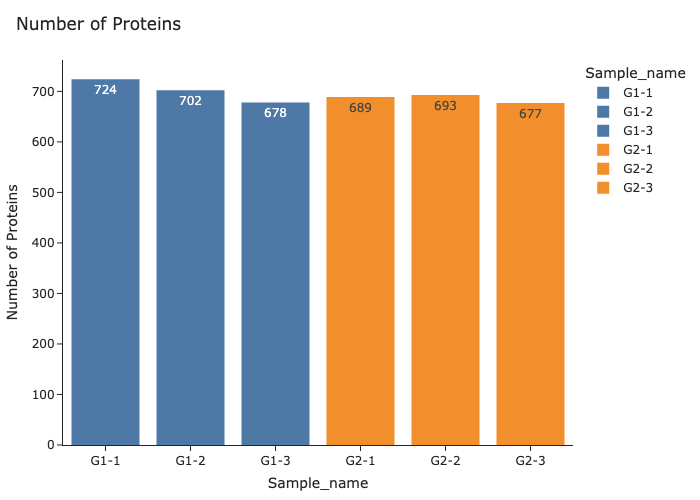

In [13]:
mm.pl.plot_id(mdata, modality="protein", colorby="condition", obs_column="sample_name")

### Intensity distribution plot


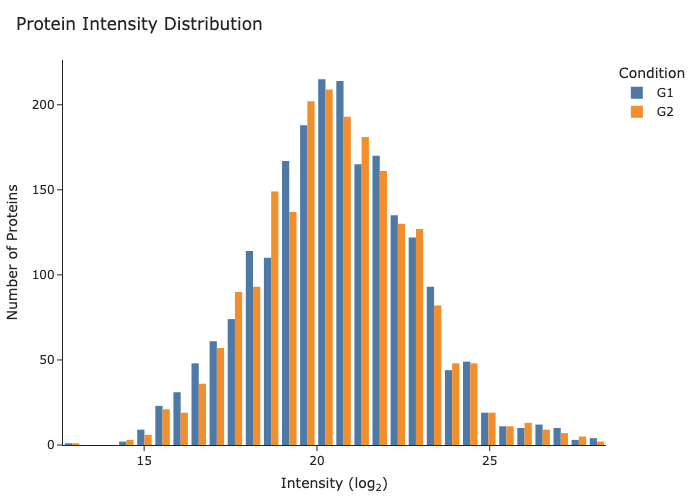

In [14]:
mm.pl.plot_intensity(mdata, modality="protein", groupby="condition", obs_column="sample_name")

## Save Data

You can save MuData object into an H5MU file.


In [15]:
mdata.write_h5mu("dia_lfq_PXD012988.h5mu")

## For DIA-NN without decoy

`DIA-NN` versions earlier than 2.0 **do not** include decoy features in the final report.tsv.

Also, even in `DIA-NN` version higher than 2.0, if the search settings in `DIA-NN` does not contain `--report-decoys`, the final will still lack decoy features.

As a result, **step-wise q-value estimation cannot be performed** and **`mm.pp.infer_protein()` cannot be applied** to `DIA-NN` version under 2.0.

Therefore, the protein groups reported directly by `DIA-NN` should be used without re-inferring them in msmu.

### Filtering - without decoy

For protein group–level q-values, use `Lib.PG.Q.Value` (when MBR is enabled) or `Global.PG.Q.Value` (when MBR is disabled) from the `DIA-NN` search results.


In [16]:
# Removing decoy features from DIA-NN output for mimicking data without decoy

mdata = mm.read_diann(identification_file=diann_idents)
del mdata["psm"].uns["decoy"]

mdata

INFO - Identification file loaded: (5069, 71)
INFO - Identification and quantification data split: (5069, 73), (5069, 6)
INFO - Decoy entries separated: (31, 9)


MuData object with n_obs × n_vars = 6 × 5038
  1 modality
    psm:	6 x 5038
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'charge', 'peptide_length', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file'
      varm:	'search_result'

In [17]:
# Adding PG Q-value column for filtering
mdata["psm"].var["pg_q_value"] = mdata["psm"].varm["search_result"]["Lib.PG.Q.Value"]

mdata = mm.pp.add_filter(mdata, modality="psm", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.add_filter(mdata, modality="psm", column="pg_q_value", keep="lt", value=0.01)
mdata = mm.pp.add_filter(mdata, modality="psm", column="proteins", keep="not_contains", value="contam_")
mdata = mm.pp.apply_filter(mdata, modality="psm")

mdata

MuData object with n_obs × n_vars = 6 × 4946
  uns:	'_cmd'
  1 modality
    psm:	6 x 4946
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'charge', 'peptide_length', 'PEP', 'q_value', 'pg_q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'filter'
      varm:	'search_result', 'filter'

### Normalisation - without decoy

Once filtering is done, you can process and summarise the data to peptide and protein levels as shown below.


In [18]:
mdata = mm.pp.log2_transform(mdata, modality="psm")
mdata = mm.pp.normalise(mdata, modality="psm", method="median")

### Summarisation - without decoy

Manually add protein group and peptide-type information from the `DIA-NN` search results into the peptide var:

- `protein_group` from `DIA-NN`'s `Protein.Group` (string value representing the protein group IDs associated with the peptide)
- `peptide_type` from `DIA-NN`'s `Proteotypic` (boolean value indicating whether the peptide is unique to a single protein group or shared among multiple protein groups).

No peptide filtering is performed at this stage.


In [19]:
mdata = mm.pp.to_peptide(mdata, calculate_q=False)

map_df = mdata["psm"].varm["search_result"][["Modified.Sequence", "Protein.Group", "Proteotypic"]]
map_df = map_df.drop_duplicates().set_index("Modified.Sequence")

mdata["peptide"].var["protein_group"] = mdata["peptide"].var_names.map(map_df["Protein.Group"])
mdata["peptide"].var["peptide_type"] = mdata["peptide"].var_names.map(map_df["Proteotypic"])
mdata["peptide"].var["peptide_type"] = ["unique" if x else "shared" for x in mdata["peptide"].var["peptide_type"]]

WARNING - Decoy data not found. Skipping decoy aggregation.


Building new peptide quantification data.


In [20]:
mdata = mm.pp.to_protein(mdata, top_n=3, rank_method="total_intensity", calculate_q=False)

INFO - Ranking features by 'total_intensity' to select top 3 features.
WARNING - Decoy data not found. Skipping decoy aggregation.


In [21]:
mdata

MuData object with n_obs × n_vars = 6 × 6656
  uns:	'_cmd'
  3 modalities
    psm:	6 x 4946
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'charge', 'peptide_length', 'PEP', 'q_value', 'pg_q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 959
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'protein_group', 'peptide_type'
      uns:	'level'
    protein:	6 x 751
      var:	'count_psm', 'count_stripped_peptide', 'PEP'
      uns:	'level'

## Citation

> Uszkoreit, J., Barkovits, K., Pacharra, S., Pfeiffer, K., Steinbach, S., Marcus, K., & Eisenacher, M. (2022). Dataset containing physiological amounts of spike-in proteins into murine C2C12 background as a ground truth quantitative LC-MS/MS reference. _Data in Brief_, 43, 108435.

> Demichev, V., Messner, C. B., Vernardis, S. I., Lilley, K. S., & Ralser, M. (2020). DIA-NN: neural networks and interference correction enable deep proteome coverage in high throughput. Nature methods, 17(1), 41-44.
